## <center>Bangla Handwritten Math Solver<center> 

In [1]:
# calculate total execution time

from datetime import datetime
start_time = datetime.now()

print('Start Time: {}'.format(start_time))

Start Time: 2022-11-01 00:49:13.246001


## Importing Libraries

In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours
from keras.models import load_model
from rembg import remove
from PIL import Image

## Removing dataset's background

In [3]:
# datadir = 'dataset'

# for folder in os.listdir(datadir):
#     path = os.path.join(datadir, folder)
#     print(path + '....')
#     img_no = 1
    
#     for image in os.listdir(path):
#         input_path = os.path.join(datadir, folder, image)
#         print('   ' + str(img_no) + '--in-- '+ input_path)
        
#         folder_path = os.path.join('clean-dataset', folder)
#         if not os.path.exists(folder_path):
#             os.makedirs(folder_path)
        
#         output_path = os.path.join('clean-dataset', folder, folder + '_' + str(img_no) + '.png')
#         print('   ' + str(img_no) + '----out---- '+ input_path)
        
#         img_no += 1

#         input = Image.open(input_path)
#         output = remove(input)
#         output.save(output_path)
        
# ########## Time Calculation #################
# print("\n\n### Time Update ###")
# end_time = datetime.now()
# print('End Time: {}'.format(end_time))
# print('Duration: {}'.format(end_time - start_time))

## Loading the Dataset 

In [4]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    print(folder + '....')
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

0....
1....
2....
3....
4....
5....
6....
7....
8....
9....
add....
div....
mul....
sub....
9062
9062
labels : ['7', '1', 'div', '0', '3', '5', 'add', '6', '8', '2', '4', 'sub', '9', 'mul']


### Time Update ###
End Time: 2022-11-01 00:49:21.280674
Duration: 0:00:08.034673


## Visualizing Images in the Dataset 

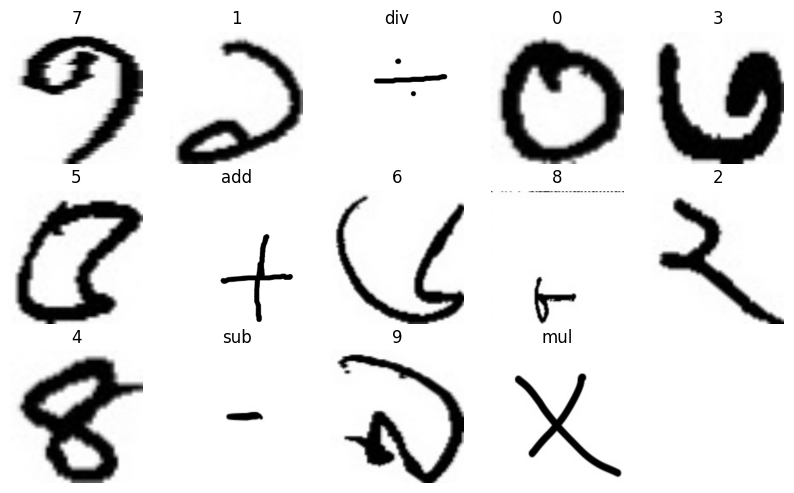

In [5]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Data Distribution of the Dataset 

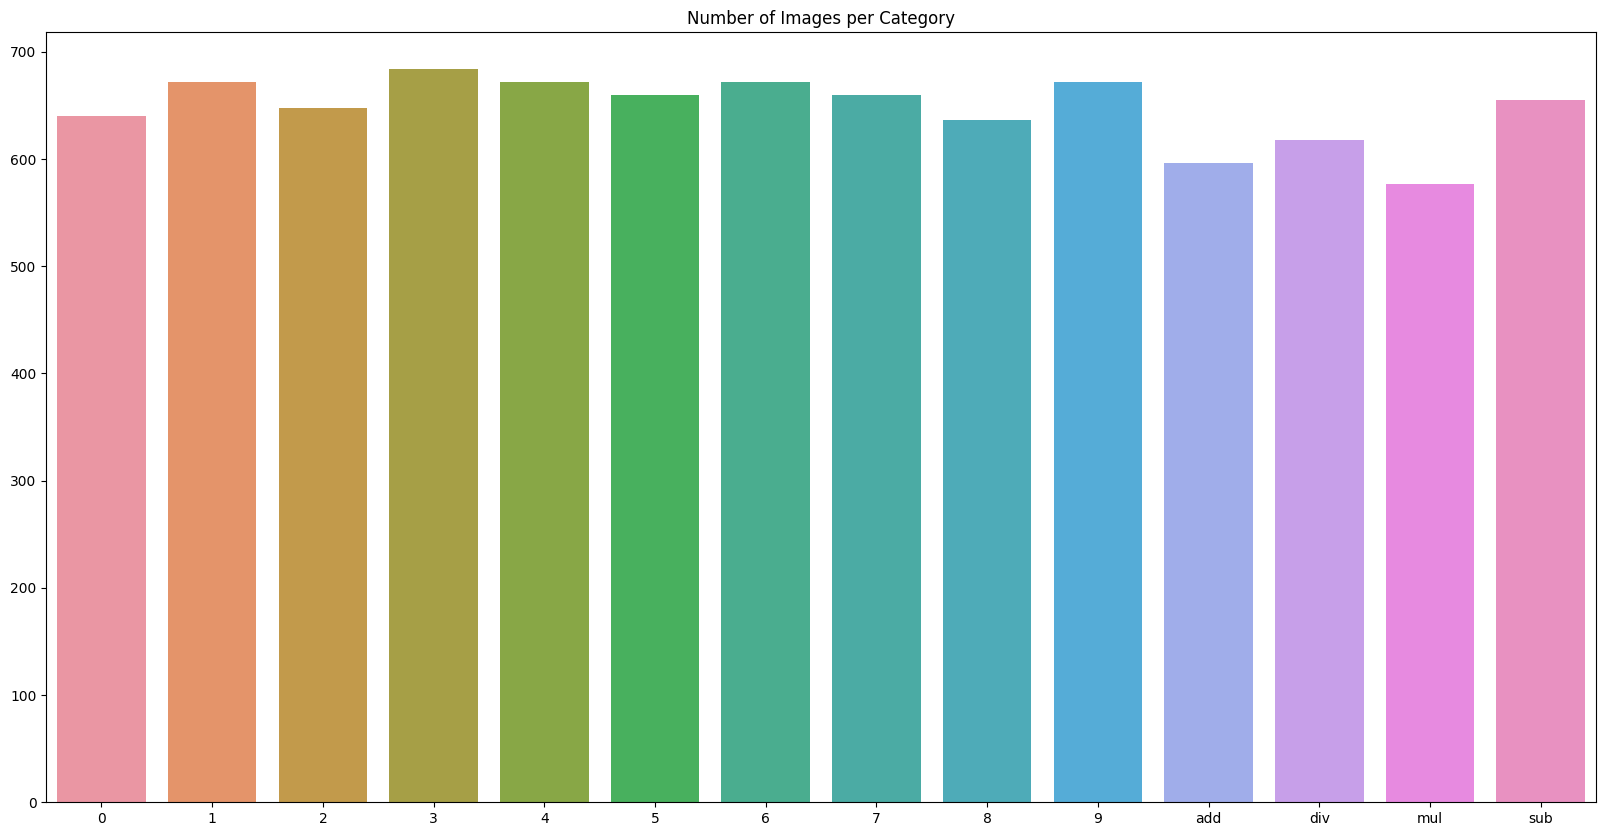

In [6]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique, y=count).set_title('Number of Images per Category')
plt.show()

In [7]:
# the dataset is not much imbalanced. So balancing is not required here much.

## Preprocessing the Data

In [8]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

9062


In [9]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(y)
print(len(y))

9062


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

print(len(Y_train))
print(len(Y_test))

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

7249
1813
7249
1813


### Time Update ###
End Time: 2022-11-01 00:49:22.755247
Duration: 0:00:09.509246


## Data Distribution in Train

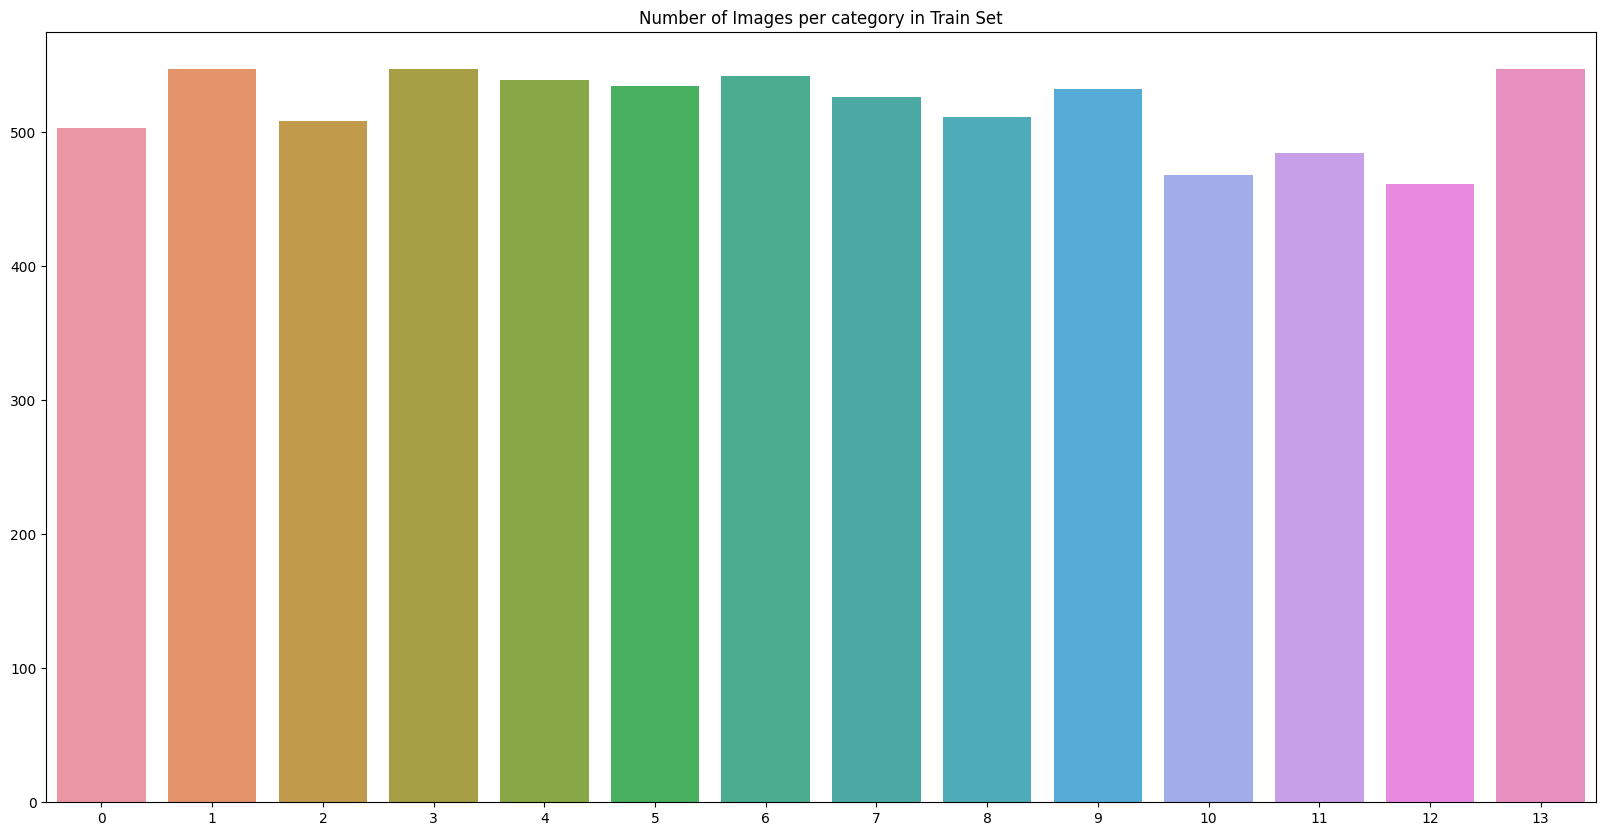

In [11]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_train, y=count_train).set_title('Number of Images per category in Train Set')
plt.show()

## Data Distribution in Test Set

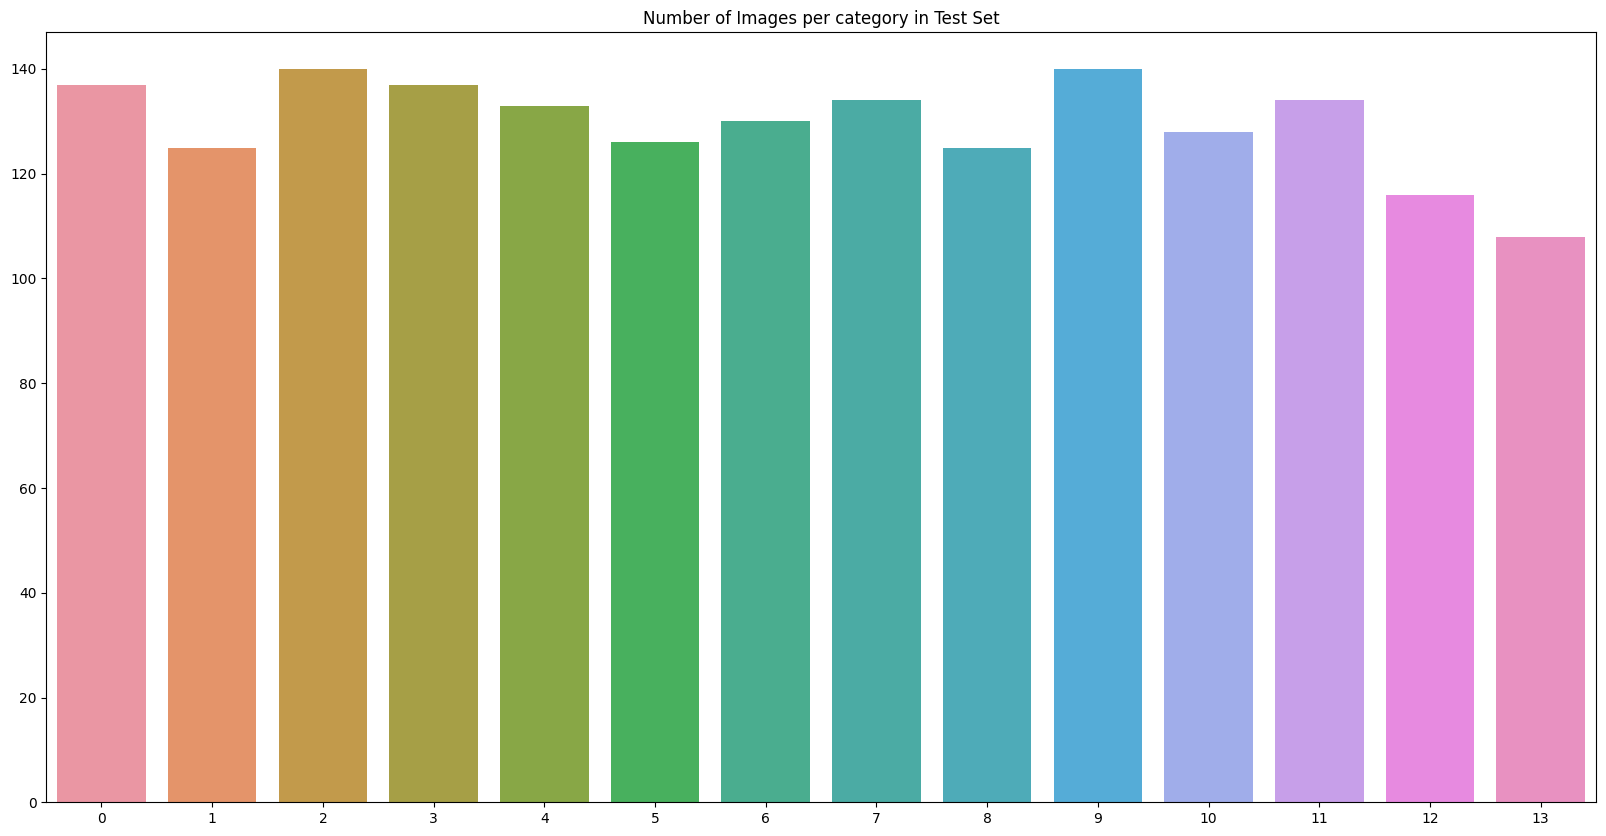

In [12]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_test, y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

## Defining the Model 

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7249, 32, 32, 1)
(1813, 32, 32, 1)
(7249, 14)
(1813, 14)


In [14]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [15]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

##  Training the Model

In [16]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('math_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]


########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))



### Time Update ###
End Time: 2022-11-01 00:49:23.710371
Duration: 0:00:10.464370


In [17]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Epoch 1/100
57/57 [==============================] - 7s 106ms/step - loss: 3.0377 - accuracy: 0.3755 - val_loss: 1.7661 - val_accuracy: 0.7341
Epoch 2/100
57/57 [==============================] - 6s 110ms/step - loss: 1.2267 - accuracy: 0.7703 - val_loss: 1.1446 - val_accuracy: 0.8158
Epoch 3/100
57/57 [==============================] - 13s 219ms/step - loss: 0.8707 - accuracy: 0.8219 - val_loss: 0.9355 - val_accuracy: 0.8367
Epoch 4/100
57/57 [==============================] - 12s 203ms/step - loss: 0.7123 - accuracy: 0.8506 - val_loss: 0.8216 - val_accuracy: 0.8632
Epoch 5/100
57/57 [==============================] - 13s 223ms/step - loss: 0.6202 - accuracy: 0.8728 - val_loss: 0.6874 - val_accuracy: 0.8803
Epoch 6/100
57/57 [==============================] - 12s 208ms/step - loss: 0.5568 - accuracy: 0.8815 - val_loss: 0.6440 - val_accuracy: 0.8842
Epoch 7/100
57/57 [==============================] - 11s 196ms/step - loss: 0.5187 - accuracy: 0.8872 - val_loss: 0.5907 - val_accuracy: 0

Epoch 58/100
57/57 [==============================] - 7s 118ms/step - loss: 0.1524 - accuracy: 0.9661 - val_loss: 0.1791 - val_accuracy: 0.9641
Epoch 59/100
57/57 [==============================] - 7s 120ms/step - loss: 0.1480 - accuracy: 0.9669 - val_loss: 0.1590 - val_accuracy: 0.9664
Epoch 60/100
57/57 [==============================] - 7s 119ms/step - loss: 0.1371 - accuracy: 0.9705 - val_loss: 0.1985 - val_accuracy: 0.9553
Epoch 61/100
57/57 [==============================] - 7s 120ms/step - loss: 0.1324 - accuracy: 0.9702 - val_loss: 0.1732 - val_accuracy: 0.9691
Epoch 62/100
57/57 [==============================] - 7s 119ms/step - loss: 0.1326 - accuracy: 0.9731 - val_loss: 0.1710 - val_accuracy: 0.9669
Epoch 63/100
57/57 [==============================] - 7s 119ms/step - loss: 0.1355 - accuracy: 0.9708 - val_loss: 0.1802 - val_accuracy: 0.9680
Epoch 64/100
57/57 [==============================] - 7s 121ms/step - loss: 0.1242 - accuracy: 0.9743 - val_loss: 0.1861 - val_accuracy:

##  Loss and Accuracy Plot

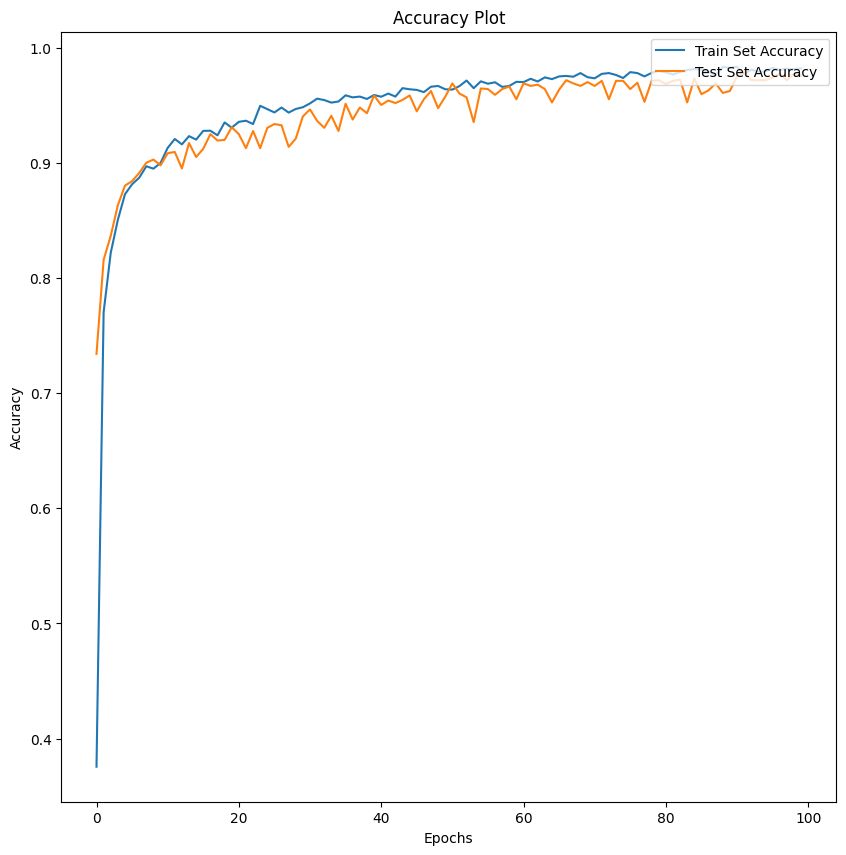

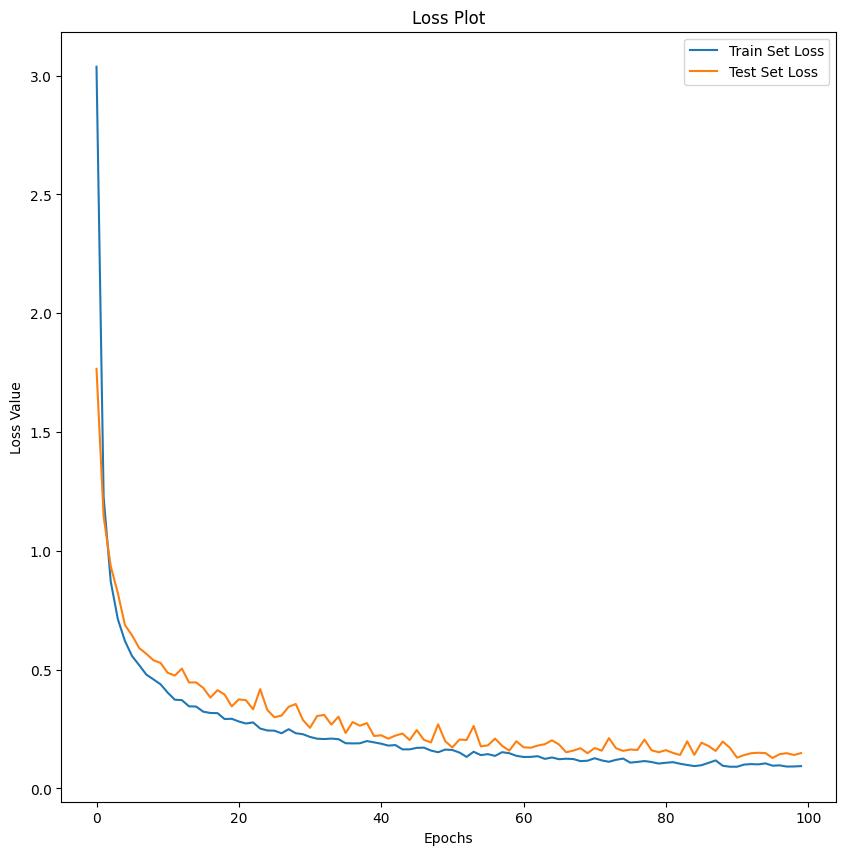

In [18]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix 

57/57 [==============================] - 1s 7ms/step


<AxesSubplot: >

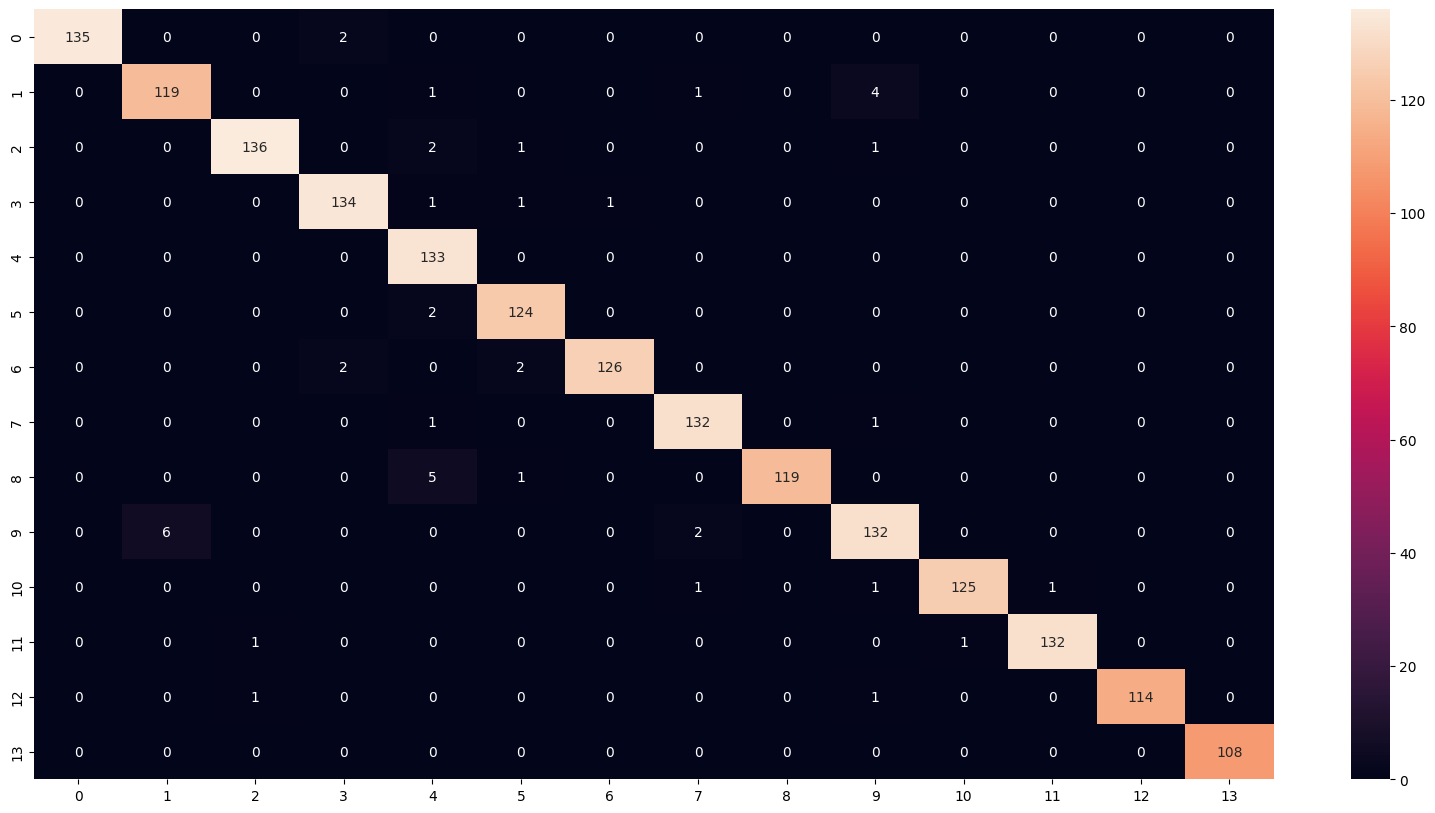

In [19]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)

matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sb.heatmap(df_cm, annot=True, fmt='d')

## Classification Report

In [20]:
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       137
           1       0.95      0.95      0.95       125
           2       0.99      0.97      0.98       140
           3       0.97      0.98      0.97       137
           4       0.92      1.00      0.96       133
           5       0.96      0.98      0.97       126
           6       0.99      0.97      0.98       130
           7       0.97      0.99      0.98       134
           8       1.00      0.95      0.98       125
           9       0.94      0.94      0.94       140
          10       0.99      0.98      0.98       128
          11       0.99      0.99      0.99       134
          12       1.00      0.98      0.99       116
          13       1.00      1.00      1.00       108

    accuracy                           0.98      1813
   macro avg       0.98      0.98      0.98      1813
weighted avg       0.98      0.98      0.98      1813



## Saving the Model 

In [21]:
model.save('math_symbol_and_digit_recognition.h5')

## Total Execution Time

In [22]:
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))



### Time Update ###
End Time: 2022-11-01 01:02:24.458441
Duration: 0:13:11.212440


## Testing the Model 

In [23]:
def test_pipeline(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 22ms/step


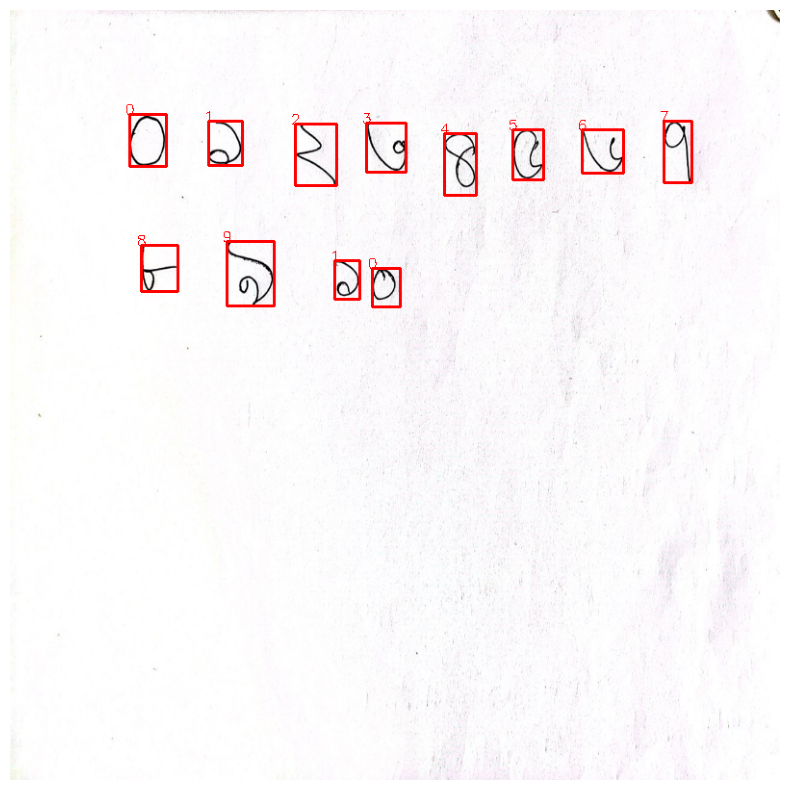

In [24]:
test_pipeline('test_data/test.jpg')

1/1 [==============================] - 0s 22ms/step


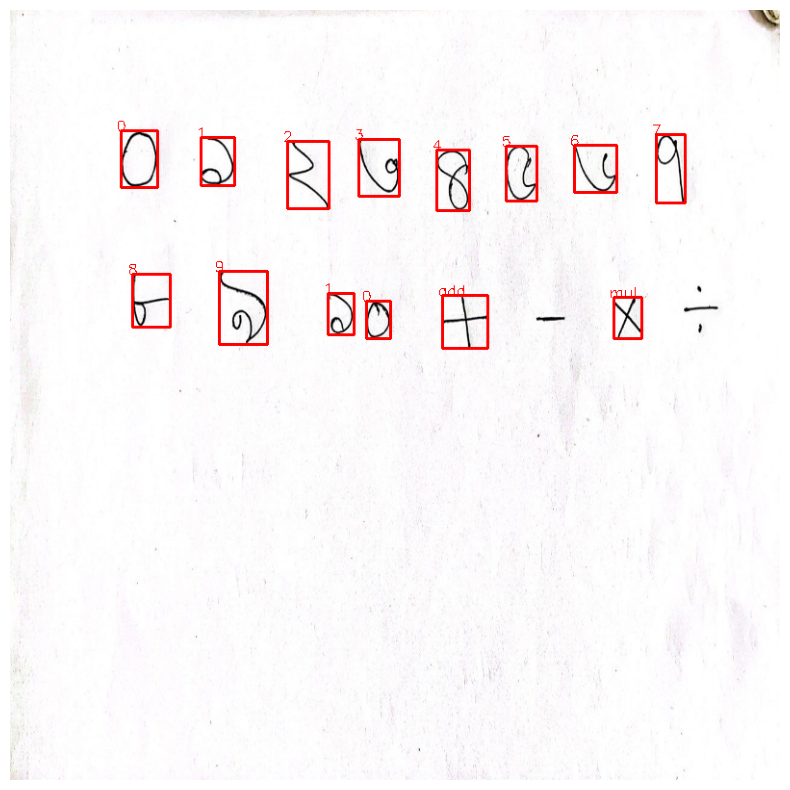

In [25]:
test_pipeline('test_data/test_2.jpg')

In [31]:
def test_pipeline_equation(image_path):
    model = load_model('math_symbol_and_digit_recognition.h5')
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
#     img = cv2.resize(img, (self.canvas_width, self.canvas_height))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    print('Number of contours found: ', len(contours))
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for i, c in enumerate(contours):
        print('Processing the image...: ', str(i+1))
        (x, y, w, h) = cv2.boundingRect(c)
        print('x: ', x, 'y: ', y, 'w: ', w, 'h: ', h)
        # if x > 0 and y > 0 and w >= 5 and h >= 25:
        if x > 0 and y > 0 and w > 5:  # cheaking weather any garbage value detecting
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            print('>>>>The {} no word is : {}'.format(i, label))
            chars.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')

    e = ''
    print('Equation: {}', chars)
    for i in chars:
        if i=='add':
            e += '+'
        elif i=='sub':
            e += '-'
        elif i=='mul':
            e += '*'
        elif i=='div':
            e += '/'
        else:
            e += i
    v = eval(e)
    print('V Result: {}', v)
    print('E Result: {}', e)

    self.label['text'] = 'The result is: {} : {}'.format(e, v) 
    print('Value of the expression {} : {}'.format(e, v))

Number of contours found:  345
Processing the image...:  1
x:  7 y:  341 w:  3 h:  3
Processing the image...:  2
x:  12 y:  548 w:  3 h:  3
Processing the image...:  3
x:  12 y:  4 w:  9 h:  4
1/1 [==============================] - 0s 87ms/step
>>>>The 2 no word is : div
Processing the image...:  4
x:  14 y:  569 w:  3 h:  3
Processing the image...:  5
x:  19 y:  740 w:  1 h:  3
Processing the image...:  6
x:  27 y:  614 w:  7 h:  5
1/1 [==============================] - 0s 23ms/step
>>>>The 5 no word is : 8
Processing the image...:  7
x:  27 y:  252 w:  4 h:  3
Processing the image...:  8
x:  65 y:  287 w:  5 h:  21
Processing the image...:  9
x:  67 y:  413 w:  2 h:  1
Processing the image...:  10
x:  67 y:  411 w:  2 h:  1
Processing the image...:  11
x:  69 y:  353 w:  3 h:  3
Processing the image...:  12
x:  70 y:  369 w:  3 h:  3
Processing the image...:  13
x:  80 y:  242 w:  1 h:  2
Processing the image...:  14
x:  82 y:  241 w:  1 h:  4
Processing the image...:  15
x:  98 y:  

1/1 [==============================] - 0s 29ms/step
>>>>The 113 no word is : 8
Processing the image...:  115
x:  343 y:  191 w:  1 h:  4
Processing the image...:  116
x:  345 y:  191 w:  1 h:  4
Processing the image...:  117
x:  348 y:  243 w:  29 h:  80
1/1 [==============================] - 0s 27ms/step
>>>>The 116 no word is : mul
Processing the image...:  118
x:  348 y:  231 w:  5 h:  10
Processing the image...:  119
x:  349 y:  489 w:  3 h:  5
Processing the image...:  120
x:  350 y:  787 w:  3 h:  13
Processing the image...:  121
x:  356 y:  718 w:  4 h:  10
Processing the image...:  122
x:  358 y:  72 w:  5 h:  17
Processing the image...:  123
x:  359 y:  562 w:  4 h:  4
Processing the image...:  124
x:  360 y:  412 w:  1 h:  3
Processing the image...:  125
x:  362 y:  84 w:  4 h:  23
Processing the image...:  126
x:  363 y:  562 w:  2 h:  2
Processing the image...:  127
x:  365 y:  340 w:  7 h:  22
1/1 [==============================] - 0s 22ms/step
>>>>The 126 no word is : 2
P

1/1 [==============================] - 0s 20ms/step
>>>>The 211 no word is : div
Processing the image...:  213
x:  455 y:  334 w:  3 h:  6
Processing the image...:  214
x:  462 y:  350 w:  3 h:  4
Processing the image...:  215
x:  464 y:  51 w:  3 h:  10
Processing the image...:  216
x:  465 y:  154 w:  9 h:  15
1/1 [==============================] - 0s 23ms/step
>>>>The 215 no word is : add
Processing the image...:  217
x:  467 y:  254 w:  26 h:  63
1/1 [==============================] - 0s 23ms/step
>>>>The 216 no word is : 1
Processing the image...:  218
x:  470 y:  286 w:  15 h:  24
1/1 [==============================] - 0s 28ms/step
>>>>The 217 no word is : 0
Processing the image...:  219
x:  470 y:  228 w:  15 h:  26
1/1 [==============================] - 0s 24ms/step
>>>>The 218 no word is : 4
Processing the image...:  220
x:  471 y:  170 w:  4 h:  16
Processing the image...:  221
x:  471 y:  37 w:  4 h:  14
Processing the image...:  222
x:  472 y:  191 w:  3 h:  4
Processing th

1/1 [==============================] - 0s 27ms/step
>>>>The 305 no word is : 7
Processing the image...:  307
x:  596 y:  530 w:  3 h:  3
Processing the image...:  308
x:  596 y:  408 w:  3 h:  7
Processing the image...:  309
x:  596 y:  397 w:  3 h:  10
Processing the image...:  310
x:  597 y:  794 w:  3 h:  4
Processing the image...:  311
x:  598 y:  783 w:  6 h:  10
1/1 [==============================] - 0s 22ms/step
>>>>The 310 no word is : 2
Processing the image...:  312
x:  598 y:  553 w:  6 h:  13
1/1 [==============================] - 0s 24ms/step
>>>>The 311 no word is : 7
Processing the image...:  313
x:  602 y:  409 w:  2 h:  12
Processing the image...:  314
x:  603 y:  397 w:  4 h:  9
Processing the image...:  315
x:  604 y:  409 w:  3 h:  10
Processing the image...:  316
x:  608 y:  275 w:  5 h:  7
Processing the image...:  317
x:  609 y:  395 w:  5 h:  40
Processing the image...:  318
x:  609 y:  234 w:  4 h:  9
Processing the image...:  319
x:  610 y:  793 w:  7 h:  7
1/1

SyntaxError: invalid syntax (<string>, line 1)

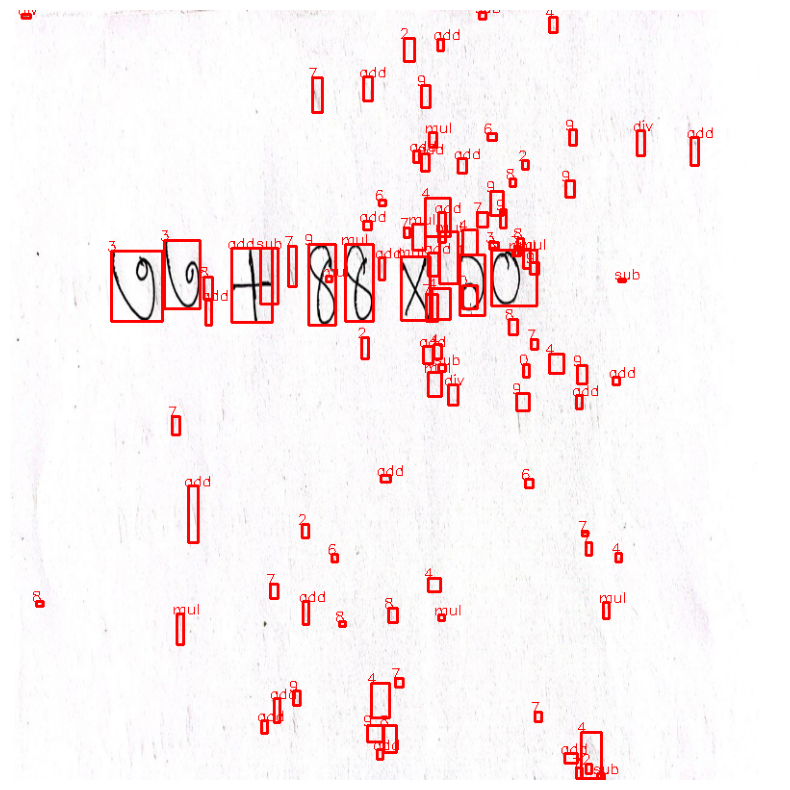

In [32]:
test_pipeline_equation('test_data/test_equation_2.jpg')